In [0]:
# Unpack dataset

# from zipfile import ZipFile

# with ZipFile('dataset.zip', 'r') as zip_file:
#    zip_file.extractall()

In [2]:
# Import all necessary libaries

import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, MaxPooling2D, Dense, DepthwiseConv2D, LeakyReLU, Add, Dropout
from keras.models import Model
from keras import models, layers, optimizers
from skimage.transform import resize

Using TensorFlow backend.


In [3]:
# Datasets path

train_path = 'dataset/train/'
test_path = 'dataset/test/'

# Padding functions for data preprocessing

def resize_pad(img):
    old_size = img.shape[:2]
    ratio = 200. / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])

    img = resize(img, output_shape=new_size, mode='edge', preserve_range=True)

    delta_w = 200 - new_size[1]
    delta_h = 200 - new_size[0]
    padding = ((delta_h // 2, delta_h - (delta_h // 2)), (delta_w // 2, delta_w - (delta_w // 2)), (0, 0))

    img = np.pad(img, padding, 'edge')

    return img

def preprocessing_train(x):
    x = resize_pad(x)
    return x


def preprocessing_val(x):
    x = resize_pad(x)
    return x

# Preapre data generators

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocessing_train,
    rescale=1. / 255,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocessing_val,
    rescale=1. / 255,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    color_mode='grayscale',
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=0
)

validation_generator = test_datagen.flow_from_directory(
    train_path,
    color_mode='grayscale',
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=0
)

labels = (train_generator.class_indices)
labels = dict((v, k) for k, v in labels.items())

print(labels)

Found 3709 images belonging to 20 classes.
Found 404 images belonging to 20 classes.
{0: 'Brick_1x1', 1: 'Brick_1x2', 2: 'Brick_1x3', 3: 'Brick_1x4', 4: 'Brick_2x2', 5: 'Brick_2x2_L', 6: 'Brick_2x2_Slope', 7: 'Brick_2x3', 8: 'Brick_2x4', 9: 'Plate_1x1', 10: 'Plate_1x1_Round', 11: 'Plate_1x1_Slope', 12: 'Plate_1x2', 13: 'Plate_1x2_Grill', 14: 'Plate_1x3', 15: 'Plate_1x4', 16: 'Plate_2x2', 17: 'Plate_2x2_L', 18: 'Plate_2x3', 19: 'Plate_2x4'}


In [4]:
inputs = Input(shape=(200, 200, 1))

net = Conv2D(filters=64, kernel_size=3, padding='same')(inputs)
net = LeakyReLU()(net)
net = MaxPooling2D()(net)

net = Conv2D(filters=64, kernel_size=3, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D()(net)

net = Conv2D(filters=64, kernel_size=3, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D()(net)

shortcut = net

net = DepthwiseConv2D(kernel_size=3, padding='same')(net)
net = LeakyReLU()(net)

net = Conv2D(filters=64, kernel_size=1, padding='same')(net)
net = LeakyReLU()(net)

net = DepthwiseConv2D(kernel_size=3, padding='same')(net)
net = LeakyReLU()(net)

net = Conv2D(filters=64, kernel_size=1, padding='same')(net)
net = LeakyReLU()(net)

net = Add()([shortcut, net])

net = Conv2D(filters=64, kernel_size=3, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D()(net)

net = Conv2D(filters=64, kernel_size=3, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D()(net)

net = DepthwiseConv2D(kernel_size=3, padding='same')(net)
net = LeakyReLU()(net)

net = Conv2D(filters=128, kernel_size=1, padding='same')(net)
net = LeakyReLU()(net)

net = Flatten()(net)

net = Dense(128, activation='relu')(net)

net = Dense(64, activation='relu')(net)

outputs = Dense(20, activation='softmax')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'top_k_categorical_accuracy'])

model.summary()


W0618 19:05:14.095414 140415829268352 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0618 19:05:14.111226 140415829268352 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0618 19:05:14.114532 140415829268352 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0618 19:05:14.221257 140415829268352 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0618 19:05:14.398065 140415829268352 deprecation_wrapp

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 200, 200, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 200, 200, 64) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 100, 100, 64) 0           leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
conv2d_2 (

In [5]:
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.samples/train_generator.batch_size,
    epochs=50, 
    validation_data=validation_generator,
    validation_steps=validation_generator.samples/validation_generator.batch_size,
    verbose=1)

W0618 19:05:14.545563 140415829268352 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0618 19:05:14.665729 140415829268352 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/50
116/115 [==============================] - 35s 301ms/step - loss: 2.9921 - acc: 0.0672 - top_k_categorical_accuracy: 0.2972 - val_loss: 2.9851 - val_acc: 0.0718 - val_top_k_categorical_accuracy: 0.3094
Epoch 2/50
116/115 [==============================] - 29s 249ms/step - loss: 2.9867 - acc: 0.0723 - top_k_categorical_accuracy: 0.3100 - val_loss: 2.9827 - val_acc: 0.0718 - val_top_k_categorical_accuracy: 0.3094
Epoch 3/50
116/115 [==============================] - 29s 253ms/step - loss: 2.9872 - acc: 0.0707 - top_k_categorical_accuracy: 0.3077 - val_loss: 2.9827 - val_acc: 0.0718 - val_top_k_categorical_accuracy: 0.3045
Epoch 4/50
116/115 [==============================] - 30s 255ms/step - loss: 2.9868 - acc: 0.0722 - top_k_categorical_accuracy: 0.3114 - val_loss: 2.9832 - val_acc: 0.0693 - val_top_k_categorical_accuracy: 0.3069
Epoch 5/50
116/115 [==============================] - 30s 255ms/step - loss: 2.9850 - acc: 0.0724 - top_k_categorical_accuracy: 0.3077 - val_loss: 2

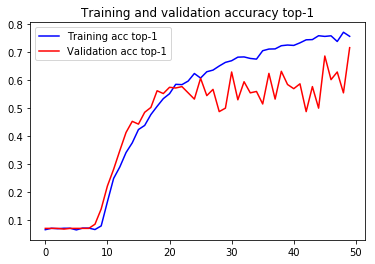

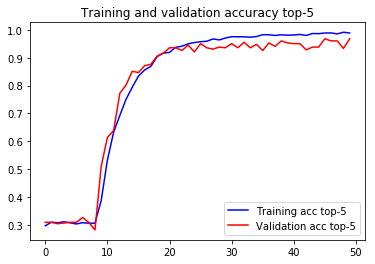

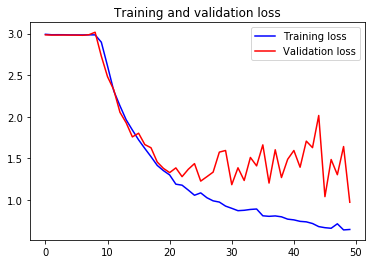

In [6]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
top_k_categorical_accuracy = history.history['top_k_categorical_accuracy']
val_top_k_categorical_accuracy = history.history['val_top_k_categorical_accuracy']

 
epochs = range(len(acc))
 
# Top-1 accuracy
plt.plot(epochs, acc, 'b', label='Training acc top-1')
plt.plot(epochs, val_acc, 'r', label='Validation acc top-1')
plt.title('Training and validation accuracy top-1')
plt.legend()
 
plt.figure()

# Top-5 accuracy
plt.plot(epochs, top_k_categorical_accuracy, 'b', label='Training acc top-5')
plt.plot(epochs, val_top_k_categorical_accuracy, 'r', label='Validation acc top-5')
plt.title('Training and validation accuracy top-5')
plt.legend()

plt.figure()

# Loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [9]:
# Create a generator for test dataset
validation_generator = test_datagen.flow_from_directory(
        test_path,
        color_mode='grayscale',
        target_size=(200, 200),
        batch_size=10,
        class_mode='categorical',
        shuffle=False)
 

ground_truth = validation_generator.classes
 
# Labels into dictionary
label2index = validation_generator.class_indices
idx2label = dict((v,k) for k,v in label2index.items())
 
# Predictions
predictions = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

Found 467 images belonging to 20 classes.
47/46 [==============================] - 2s 39ms/step


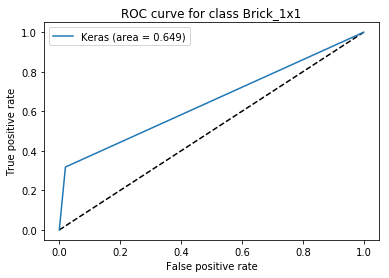

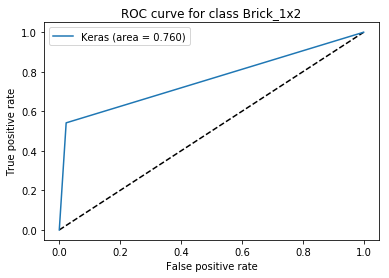

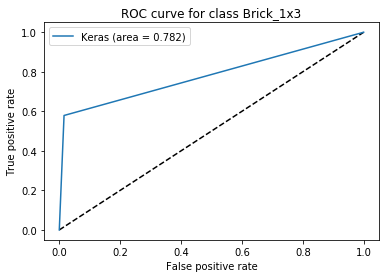

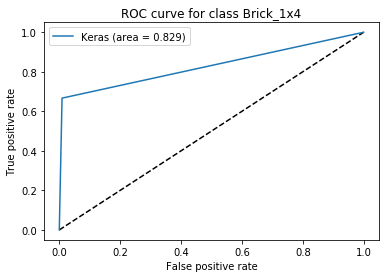

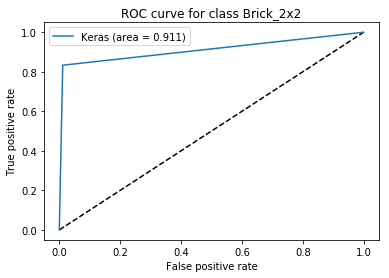

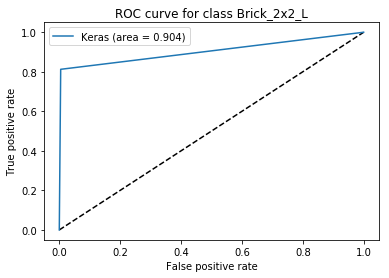

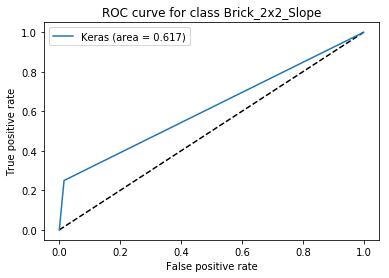

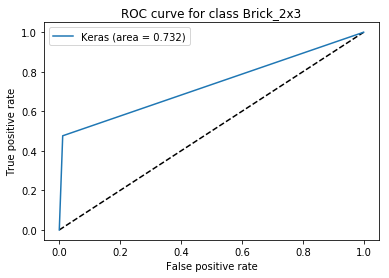

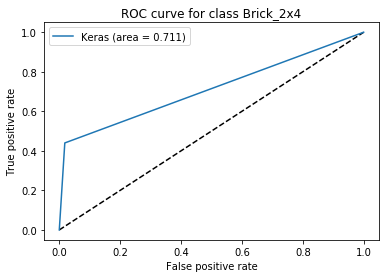

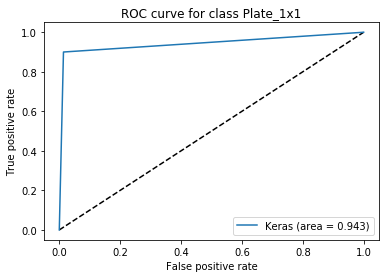

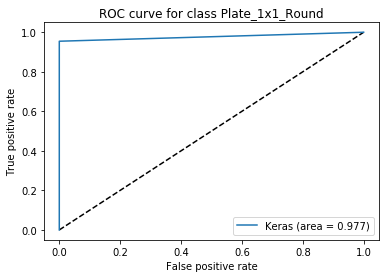

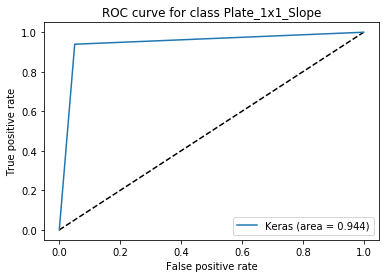

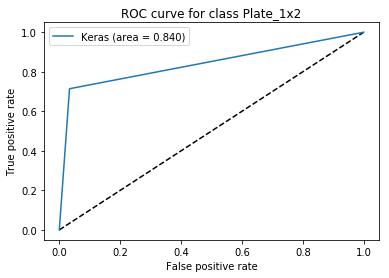

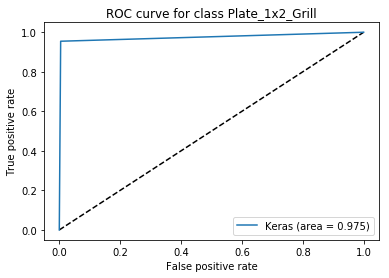

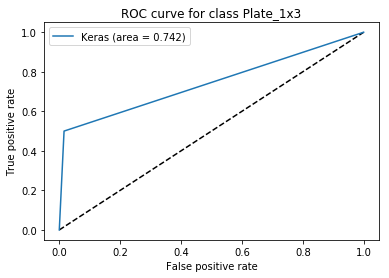

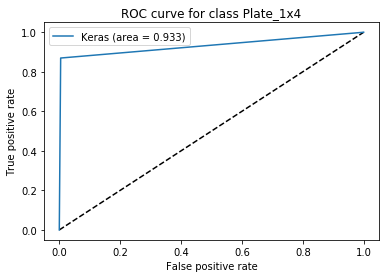

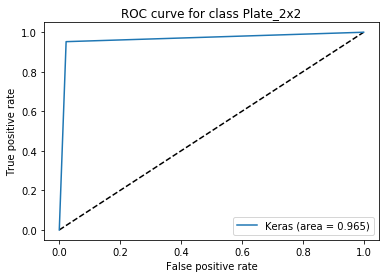

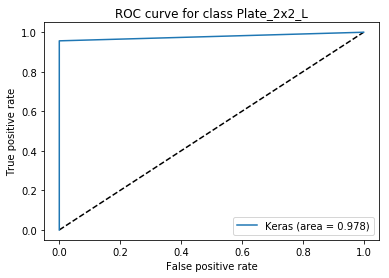

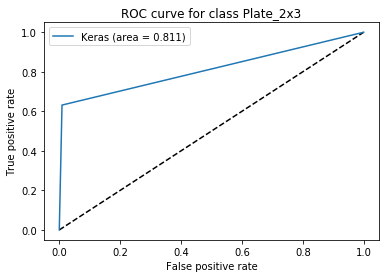

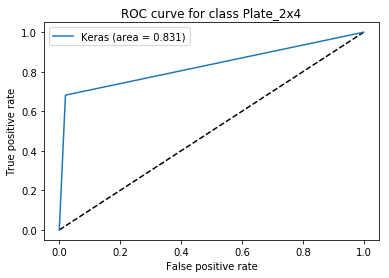

In [11]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize and transpose results and ground truth
y = label_binarize(ground_truth, classes=[x for x in range(20)])
y_pred = label_binarize(predicted_classes, classes=[x for x in range(20)])
y = y.T
y_pred = y_pred.T

# Display all roc's curves
for i in range(20):
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y[i], y_pred[i])

  auc_keras = auc(fpr_keras, tpr_keras)

  plt.figure(i+1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve for class '+ idx2label[i])
  plt.legend(loc='best')
  plt.show()

In [12]:
good_predictions = 0
for prediction, label in zip(predicted_classes, ground_truth):
  if prediction == label:
    good_predictions += 1

result = good_predictions/len(predicted_classes)

print("Result: ", result)
print("Good predictions: ", good_predictions)
print("All predictions: ", len(predicted_classes))

Result:  0.7130620985010707
Good predictions:  333
All predictions:  467
